# IMPORTS

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import math, numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import entropy

# DATASETS

In [ ]:
from google.colab import drive

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

drive.mount('/content/drive')

mean = [0.5070, 0.4865, 0.4409]
std = [0.2673, 0.2564, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_transform)
testset = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=16)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=16)

## Teacher

In [11]:
teacher = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True).to(device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


# Students

## SETUP

In [22]:
student_ind = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_lm = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_hint = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)

experiment_dir = "/content/drive/MyDrive/AI_EDGE/kd_experiments"
os.makedirs(experiment_dir, exist_ok=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
epochs = 50
batch_size = 128
lr = 0.01         # recommended for SGD
momentum = 0.9
weight_decay = 5e-4
T = 3.0          # KD temperature
alpha_kd = 0.6   # weight for distillation

# Bench Mark - Independent

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student_ind.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [3]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        _, pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.2f}%'})
    return total_loss / total, 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        pbar = tqdm(loader)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.2f}%'})
    return total_loss / total, 100. * correct / total

In [ ]:
best_val = -1.0
logs_ind = []

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_epoch(student_ind, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(student_ind, test_loader, criterion, device)
    scheduler.step()

    if val_acc > best_val:
        best_val = val_acc
        torch.save(student_ind.state_dict(), os.path.join(experiment_dir, "student_independent_best.pth"))

    logs_ind.append((ep, tr_loss, tr_acc, val_loss, val_acc))
    print(f"Independent E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f}")

# save logs
np.save(os.path.join(experiment_dir, "independent_logs.npy"), np.array(logs_ind, dtype=object))
print("Done. Best val acc:", best_val)


100%|██████████| 79/79 [00:02<00:00, 33.38it/s, loss=4.343, acc=2.84%]


Independent E001: TrAcc 1.73 ValAcc 2.84


100%|██████████| 79/79 [00:03<00:00, 23.83it/s, loss=3.813, acc=8.89%]


Independent E002: TrAcc 5.16 ValAcc 8.89


100%|██████████| 79/79 [00:02<00:00, 33.38it/s, loss=3.555, acc=12.87%]


Independent E003: TrAcc 9.17 ValAcc 12.87


100%|██████████| 79/79 [00:02<00:00, 33.88it/s, loss=3.379, acc=15.95%]


Independent E004: TrAcc 13.23 ValAcc 15.95


100%|██████████| 79/79 [00:02<00:00, 29.39it/s, loss=3.008, acc=23.00%]


Independent E005: TrAcc 18.09 ValAcc 23.00


100%|██████████| 79/79 [00:02<00:00, 34.04it/s, loss=2.866, acc=26.41%]


Independent E006: TrAcc 21.85 ValAcc 26.41


100%|██████████| 79/79 [00:02<00:00, 28.77it/s, loss=2.688, acc=29.15%]


Independent E007: TrAcc 25.68 ValAcc 29.15


100%|██████████| 79/79 [00:02<00:00, 31.59it/s, loss=2.506, acc=32.89%]


Independent E008: TrAcc 28.86 ValAcc 32.89


100%|██████████| 79/79 [00:02<00:00, 34.73it/s, loss=2.395, acc=36.23%]


Independent E009: TrAcc 32.36 ValAcc 36.23


100%|██████████| 79/79 [00:02<00:00, 30.01it/s, loss=2.281, acc=38.32%]


Independent E010: TrAcc 35.28 ValAcc 38.32


100%|██████████| 79/79 [00:02<00:00, 31.31it/s, loss=2.118, acc=42.70%]


Independent E011: TrAcc 37.96 ValAcc 42.70


100%|██████████| 79/79 [00:02<00:00, 34.15it/s, loss=2.140, acc=42.15%]


Independent E012: TrAcc 40.09 ValAcc 42.15


100%|██████████| 79/79 [00:03<00:00, 24.21it/s, loss=2.069, acc=44.18%]


Independent E013: TrAcc 42.61 ValAcc 44.18


100%|██████████| 79/79 [00:02<00:00, 33.46it/s, loss=1.941, acc=47.41%]


Independent E014: TrAcc 44.69 ValAcc 47.41


100%|██████████| 79/79 [00:02<00:00, 33.98it/s, loss=2.003, acc=46.03%]


Independent E015: TrAcc 46.56 ValAcc 46.03


100%|██████████| 79/79 [00:02<00:00, 27.57it/s, loss=1.873, acc=49.61%]


Independent E016: TrAcc 48.21 ValAcc 49.61


100%|██████████| 79/79 [00:02<00:00, 32.70it/s, loss=1.844, acc=49.80%]


Independent E017: TrAcc 50.13 ValAcc 49.80


100%|██████████| 79/79 [00:02<00:00, 31.67it/s, loss=1.808, acc=51.30%]


Independent E018: TrAcc 51.72 ValAcc 51.30


100%|██████████| 79/79 [00:02<00:00, 32.85it/s, loss=1.730, acc=52.90%]


Independent E019: TrAcc 53.21 ValAcc 52.90


100%|██████████| 79/79 [00:02<00:00, 34.35it/s, loss=1.827, acc=51.25%]


Independent E020: TrAcc 55.02 ValAcc 51.25


100%|██████████| 79/79 [00:03<00:00, 24.17it/s, loss=1.688, acc=53.98%]


Independent E021: TrAcc 56.24 ValAcc 53.98


100%|██████████| 79/79 [00:02<00:00, 34.28it/s, loss=1.735, acc=53.76%]


Independent E022: TrAcc 57.66 ValAcc 53.76


100%|██████████| 79/79 [00:02<00:00, 35.03it/s, loss=1.669, acc=55.36%]


Independent E023: TrAcc 59.26 ValAcc 55.36


100%|██████████| 79/79 [00:02<00:00, 29.18it/s, loss=1.676, acc=54.66%]


Independent E024: TrAcc 60.82 ValAcc 54.66


100%|██████████| 79/79 [00:02<00:00, 34.12it/s, loss=1.662, acc=55.33%]


Independent E025: TrAcc 61.96 ValAcc 55.33


100%|██████████| 79/79 [00:03<00:00, 24.20it/s, loss=1.584, acc=57.51%]


Independent E026: TrAcc 63.57 ValAcc 57.51


100%|██████████| 79/79 [00:02<00:00, 34.68it/s, loss=1.646, acc=56.85%]


Independent E027: TrAcc 64.80 ValAcc 56.85


100%|██████████| 79/79 [00:02<00:00, 33.84it/s, loss=1.574, acc=58.52%]


Independent E028: TrAcc 66.01 ValAcc 58.52


100%|██████████| 79/79 [00:02<00:00, 29.87it/s, loss=1.546, acc=59.03%]


Independent E029: TrAcc 67.81 ValAcc 59.03


100%|██████████| 79/79 [00:02<00:00, 34.91it/s, loss=1.559, acc=59.33%]


Independent E030: TrAcc 68.98 ValAcc 59.33


100%|██████████| 79/79 [00:02<00:00, 29.89it/s, loss=1.564, acc=59.48%]


Independent E031: TrAcc 70.60 ValAcc 59.48


100%|██████████| 79/79 [00:02<00:00, 33.81it/s, loss=1.547, acc=60.05%]


Independent E032: TrAcc 71.93 ValAcc 60.05


100%|██████████| 79/79 [00:02<00:00, 34.63it/s, loss=1.604, acc=60.04%]


Independent E033: TrAcc 73.40 ValAcc 60.04


100%|██████████| 79/79 [00:03<00:00, 22.78it/s, loss=1.541, acc=60.99%]


Independent E034: TrAcc 74.56 ValAcc 60.99


100%|██████████| 79/79 [00:02<00:00, 33.81it/s, loss=1.583, acc=60.85%]


Independent E035: TrAcc 76.24 ValAcc 60.85


100%|██████████| 79/79 [00:02<00:00, 34.01it/s, loss=1.554, acc=61.71%]


Independent E036: TrAcc 77.67 ValAcc 61.71


100%|██████████| 79/79 [00:03<00:00, 23.86it/s, loss=1.574, acc=61.55%]


Independent E037: TrAcc 79.18 ValAcc 61.55


100%|██████████| 79/79 [00:02<00:00, 33.73it/s, loss=1.570, acc=62.07%]


Independent E038: TrAcc 80.45 ValAcc 62.07


100%|██████████| 79/79 [00:02<00:00, 29.49it/s, loss=1.558, acc=62.76%]


Independent E039: TrAcc 81.66 ValAcc 62.76


100%|██████████| 79/79 [00:02<00:00, 34.10it/s, loss=1.570, acc=62.29%]


Independent E040: TrAcc 82.81 ValAcc 62.29


100%|██████████| 79/79 [00:02<00:00, 33.78it/s, loss=1.595, acc=62.76%]


Independent E041: TrAcc 83.94 ValAcc 62.76


100%|██████████| 79/79 [00:03<00:00, 23.89it/s, loss=1.594, acc=63.41%]


Independent E042: TrAcc 85.04 ValAcc 63.41


100%|██████████| 79/79 [00:02<00:00, 33.56it/s, loss=1.613, acc=62.71%]


Independent E043: TrAcc 86.02 ValAcc 62.71


100%|██████████| 79/79 [00:02<00:00, 30.75it/s, loss=1.606, acc=63.25%]


Independent E044: TrAcc 86.84 ValAcc 63.25


100%|██████████| 79/79 [00:02<00:00, 34.53it/s, loss=1.607, acc=63.42%]


Independent E045: TrAcc 87.41 ValAcc 63.42


100%|██████████| 79/79 [00:02<00:00, 34.73it/s, loss=1.618, acc=63.43%]


Independent E046: TrAcc 87.72 ValAcc 63.43


100%|██████████| 79/79 [00:03<00:00, 25.06it/s, loss=1.611, acc=63.60%]


Independent E047: TrAcc 88.37 ValAcc 63.60


100%|██████████| 79/79 [00:02<00:00, 33.80it/s, loss=1.621, acc=63.58%]


Independent E048: TrAcc 88.47 ValAcc 63.58


100%|██████████| 79/79 [00:02<00:00, 33.26it/s, loss=1.623, acc=63.78%]


Independent E049: TrAcc 88.69 ValAcc 63.78


100%|██████████| 79/79 [00:03<00:00, 24.36it/s, loss=1.615, acc=63.76%]

Independent E050: TrAcc 88.70 ValAcc 63.76
Done. Best val acc: 63.78


# Task 1 - Logit Matching

In [ ]:
optimizer = optim.SGD(student_lm.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [4]:
ce_loss = nn.CrossEntropyLoss()

def kd_loss(student_logits, teacher_logits, T=4.0):
    # KL(soft_teacher || soft_student) * T^2
    p_t = F.softmax(teacher_logits / T, dim=1)
    log_p_s = F.log_softmax(student_logits / T, dim=1)
    kl = (p_t * (torch.log(p_t + 1e-12) - log_p_s)).sum(dim=1).mean()
    return kl * (T * T)

# metric helpers
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds.eq(targets).sum().item(), targets.size(0))

def avg_kl_between_models(student_logits, teacher_logits):
    p_t = F.softmax(teacher_logits, dim=1)
    log_p_s = F.log_softmax(student_logits, dim=1)
    return (p_t * (torch.log(p_t + 1e-12) - log_p_s)).sum(dim=1).mean().item()


In [ ]:
def train_one_epoch(student, teacher, loader, optimizer, ep):
    student.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_kl = 0.0

    pbar = tqdm(loader, desc=f"Train[{ep}]", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            t_logits = teacher(x)
        s_logits = student(x)
        loss_ce = ce_loss(s_logits, y)
        loss_kd = kd_loss(s_logits, t_logits, T=T)
        loss = (1.0 - alpha_kd) * loss_ce + alpha_kd * loss_kd
        kl = avg_kl_between_models(s_logits.detach(), t_logits.detach())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        c, n = accuracy_from_logits(s_logits, y)
        correct += c
        total += n
        running_kl += kl * y.size(0)

        pbar.set_postfix({
            "loss": f"{loss.item():.3f}",
            "acc": f"{100.0 * correct / total:.2f}%",
            "KL": f"{running_kl / total:.4f}"
        })

    return running_loss / total, 100.0 * correct / total, running_kl / total


In [ ]:
def evaluate_model(student, teacher, loader, ep):
    student.eval()
    teacher.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    running_kl = 0.0
    all_student_probs = []
    all_teacher_probs = []

    pbar = tqdm(loader, desc=f"Eval[{ep}]", leave=False)
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            s_logits = student(x)
            t_logits = teacher(x)

            loss = ce_loss(s_logits, y)
            total_loss += loss.item() * y.size(0)
            c, n = accuracy_from_logits(s_logits, y)
            correct += c
            total += n

            if t_logits is not None:
                running_kl += avg_kl_between_models(s_logits, t_logits) * y.size(0)
                all_teacher_probs.append(F.softmax(t_logits, dim=1).cpu().numpy())

            all_student_probs.append(F.softmax(s_logits, dim=1).cpu().numpy())

            pbar.set_postfix({
                "loss": f"{loss.item():.3f}",
                "acc": f"{100.0 * correct / total:.2f}%",
                "KL": f"{running_kl / total:.4f}"
            })

    avg_kl = running_kl / total if total > 0 else 0.0
    return total_loss / total, 100.0 * correct / total, avg_kl


In [ ]:
best_val = -1.0
logs_lm = []
for ep in range(1, epochs+1):
    tr_loss, tr_acc, tr_kl = train_one_epoch(student_lm, teacher, train_loader, optimizer, ep)
    val_loss, val_acc, val_kl = evaluate_model(student_lm, teacher, test_loader, ep)
    scheduler.step()
    if val_acc > best_val:
        best_val = val_acc
        torch.save(student_lm.state_dict(), os.path.join(experiment_dir, f"student_lm_best.pth"))
    logs_lm.append((ep, tr_loss, tr_acc, tr_kl, val_loss, val_acc, val_kl))
    print(f"{ep} E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f} TrKL {tr_kl:.4f} ValKL {val_kl:.4f}")

np.save(os.path.join(experiment_dir, f"lm_logs.npy"), np.array(logs_lm, dtype=object))
print("Done. Best val acc:", best_val)

1 E001: TrAcc 2.30 ValAcc 3.25 TrKL 4.5323 ValKL 4.0471


2 E002: TrAcc 3.34 ValAcc 4.76 TrKL 4.4079 ValKL 3.9256


3 E003: TrAcc 4.93 ValAcc 6.68 TrKL 4.3098 ValKL 3.7345


4 E004: TrAcc 6.09 ValAcc 7.34 TrKL 4.2497 ValKL 3.6946


5 E005: TrAcc 7.52 ValAcc 8.54 TrKL 4.1820 ValKL 3.7116


6 E006: TrAcc 9.27 ValAcc 10.85 TrKL 4.1058 ValKL 3.9654


7 E007: TrAcc 11.18 ValAcc 11.76 TrKL 4.0280 ValKL 3.6758


8 E008: TrAcc 13.11 ValAcc 12.62 TrKL 3.9560 ValKL 3.7105


9 E009: TrAcc 14.79 ValAcc 14.27 TrKL 3.8858 ValKL 3.7531


10 E010: TrAcc 16.84 ValAcc 21.02 TrKL 3.8255 ValKL 3.2486


11 E011: TrAcc 18.99 ValAcc 24.17 TrKL 3.7323 ValKL 2.9954


12 E012: TrAcc 20.50 ValAcc 22.50 TrKL 3.6811 ValKL 3.3179


13 E013: TrAcc 22.41 ValAcc 25.93 TrKL 3.6039 ValKL 3.0854


14 E014: TrAcc 24.73 ValAcc 26.23 TrKL 3.5331 ValKL 3.0890


15 E015: TrAcc 26.39 ValAcc 26.50 TrKL 3.4523 ValKL 3.2125


16 E016: TrAcc 27.87 ValAcc 32.59 TrKL 3.3883 ValKL 2.7084


17 E017: TrAcc 29.99 ValAcc 33.96 TrKL 3.3310 ValKL 2.7591


18 E018: TrAcc 31.17 ValAcc 32.56 TrKL 3.2717 ValKL 2.9775


19 E019: TrAcc 33.15 ValAcc 36.78 TrKL 3.1852 ValKL 2.6124


20 E020: TrAcc 35.33 ValAcc 33.17 TrKL 3.0960 ValKL 3.1178


21 E021: TrAcc 36.85 ValAcc 39.29 TrKL 3.0321 ValKL 2.5631


22 E022: TrAcc 39.10 ValAcc 39.68 TrKL 2.9444 ValKL 2.7612


23 E023: TrAcc 40.75 ValAcc 42.02 TrKL 2.8703 ValKL 2.6406


24 E024: TrAcc 42.62 ValAcc 44.40 TrKL 2.7967 ValKL 2.3950


25 E025: TrAcc 44.79 ValAcc 45.69 TrKL 2.6822 ValKL 2.3364


26 E026: TrAcc 46.62 ValAcc 46.69 TrKL 2.5956 ValKL 2.3161


27 E027: TrAcc 48.60 ValAcc 48.48 TrKL 2.5113 ValKL 2.2317


28 E028: TrAcc 50.58 ValAcc 51.24 TrKL 2.4003 ValKL 2.1239


29 E029: TrAcc 52.48 ValAcc 50.53 TrKL 2.3150 ValKL 2.3164


30 E030: TrAcc 54.60 ValAcc 51.60 TrKL 2.2081 ValKL 2.1076


31 E031: TrAcc 56.50 ValAcc 52.77 TrKL 2.1205 ValKL 2.1604


32 E032: TrAcc 58.38 ValAcc 53.35 TrKL 2.0115 ValKL 2.1484


33 E033: TrAcc 60.17 ValAcc 56.13 TrKL 1.9264 ValKL 1.9626


34 E034: TrAcc 62.36 ValAcc 57.81 TrKL 1.8053 ValKL 1.8792


35 E035: TrAcc 64.21 ValAcc 57.97 TrKL 1.7139 ValKL 1.9251


36 E036: TrAcc 66.32 ValAcc 59.00 TrKL 1.5885 ValKL 1.9219


37 E037: TrAcc 68.26 ValAcc 59.81 TrKL 1.4942 ValKL 1.8452


38 E038: TrAcc 70.23 ValAcc 62.21 TrKL 1.3953 ValKL 1.6976


39 E039: TrAcc 72.35 ValAcc 63.35 TrKL 1.2812 ValKL 1.6704


40 E040: TrAcc 74.52 ValAcc 63.82 TrKL 1.1795 ValKL 1.6602


41 E041: TrAcc 76.23 ValAcc 64.21 TrKL 1.0840 ValKL 1.6928


42 E042: TrAcc 78.27 ValAcc 64.55 TrKL 0.9945 ValKL 1.6478


43 E043: TrAcc 79.90 ValAcc 65.39 TrKL 0.9011 ValKL 1.6261


44 E044: TrAcc 81.21 ValAcc 66.02 TrKL 0.8266 ValKL 1.6017


45 E045: TrAcc 82.69 ValAcc 66.60 TrKL 0.7491 ValKL 1.5562


46 E046: TrAcc 83.91 ValAcc 66.69 TrKL 0.6938 ValKL 1.5660


47 E047: TrAcc 84.99 ValAcc 67.20 TrKL 0.6469 ValKL 1.5716


48 E048: TrAcc 85.47 ValAcc 67.33 TrKL 0.6178 ValKL 1.5606


49 E049: TrAcc 85.92 ValAcc 67.43 TrKL 0.5927 ValKL 1.5761


50 E050: TrAcc 86.01 ValAcc 67.60 TrKL 0.5929 ValKL 1.5696
Done. Best val acc: 67.6


# Task 2 - Logit Matching Issues Analysis

## 4-Class

In [12]:
teacher_logits = np.array([1.0, 4.0, 3.0, 2.0])
student1_logits = np.array([1.0, 2.8, 3.0, 2.0])
student2_logits = np.array([0.1, 0.4, 0.3, 0.2])

labels = ['Cat', 'Dog', 'Bird', 'Frog']

teacher_probs = softmax(teacher_logits)
student1_probs = softmax(student1_logits)
student2_probs = softmax(student2_logits)

kl1_orig = entropy(teacher_probs, student1_probs)
kl2_orig = entropy(teacher_probs, student2_probs)

In [13]:
print("ORIGINAL Logits")
print("Teacher:", teacher_logits)
print("Student A:", student1_logits)
print("Student B:", student2_logits, "\n")

print("ORIGINAL Predicted Classes")
print("Teacher:", labels[teacher_probs.argmax()])
print("Student A:", labels[student1_probs.argmax()], "(Wrong)")
print("Student B:", labels[student2_probs.argmax()], "(Correct)\n")

print("ORIGINAL KL Divergence")
print(f"Student A: {kl1_orig:.4f} (Lower and wrong preference)")
print(f"Student B: {kl2_orig:.4f} (Higher)\n")

ORIGINAL Logits
Teacher: [1. 4. 3. 2.]
Student A: [1.  2.8 3.  2. ]
Student B: [0.1 0.4 0.3 0.2] 

ORIGINAL Predicted Classes
Teacher: Dog
Student A: Bird (Wrong)
Student B: Dog (Correct)

ORIGINAL KL Divergence
Student A: 0.1749 (Lower and wrong preference)
Student B: 0.3457 (Higher)



In [14]:
def standardize(x):
    return (x - x.mean()) / (x.std() + 1e-8)

teacher_std = standardize(teacher_logits)
student1_std = standardize(student1_logits)
student2_std = standardize(student2_logits)

teacher_probs_std = softmax(teacher_std)
student1_probs_std = softmax(student1_std)
student2_probs_std = softmax(student2_std)

kl1_std = entropy(teacher_probs_std, student1_probs_std)
kl2_std = entropy(teacher_probs_std, student2_probs_std)

In [15]:
print("STANDARDIZED Logits")
print("Teacher:", teacher_std)
print("Student A:", student1_std)
print("Student B:", student2_std, "\n")

print("STANDARDIZED Probabilities")
print("Teacher:", teacher_probs_std)
print("Student A:", student1_probs_std)
print("Student B:", student2_probs_std, "\n")

print("STANDARDIZED Predicted Classes")
print("Teacher:", labels[teacher_probs_std.argmax()])
print("Student A:", labels[student1_probs_std.argmax()], "(Still Wrong but that's expected)")
print("Student B:", labels[student2_probs_std.argmax()], "(Still Correct)\n")

print("STANDARDIZED KL Divergence")
print(f"Student A: {kl1_std:.4f} (Higher now and correct student is preferred)")
print(f"Student B: {kl2_std:.4f} (Lower now and this is the desired outcome)")

STANDARDIZED Logits
Teacher: [-1.34164077  1.34164077  0.44721359 -0.44721359]
Student A: [-1.5240015   0.76200075  1.016001   -0.25400025]
Student B: [-1.34164067  1.34164067  0.44721356 -0.44721356] 

STANDARDIZED Probabilities
Teacher: [0.04156006 0.60814976 0.248637   0.10165318]
Student A: [0.03693294 0.3632554  0.46829873 0.13151293]
Student B: [0.04156007 0.60814974 0.248637   0.10165319] 

STANDARDIZED Predicted Classes
Teacher: Dog
Student A: Bird (Still Wrong but that's expected)
Student B: Dog (Still Correct)

STANDARDIZED KL Divergence
Student A: 0.1347 (Higher now and correct student is preferred)
Student B: 0.0000 (Lower now and this is the desired outcome)


## 10-Class

In [16]:
teacher_logits = np.array([1.0, 4.0, 3.0, 2.0, 7.0, 0.5, 2.5, 1.5, 3.5, 4.5])
student1_logits = np.array([1.1, 4.2, 3.1, 2.1, 6.8, 0.6, 2.6, 1.6, 3.6, 7.5])
student2_logits = np.array([0.1, 0.4, 0.3, 0.2, 0.7, 0.05, 0.25, 0.15, 0.35, 0.45])

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

teacher_probs = softmax(teacher_logits)
student1_probs = softmax(student1_logits)
student2_probs = softmax(student2_logits)

kl1_orig = entropy(teacher_probs, student1_probs)
kl2_orig = entropy(teacher_probs, student2_probs)

In [17]:
print("ORIGINAL Logits")
print("Teacher:", teacher_logits)
print("Student A:", student1_logits)
print("Student B:", student2_logits, "\n")

print("ORIGINAL Predicted Classes")
print("Teacher:", labels[teacher_probs.argmax()])
print("Student A:", labels[student1_probs.argmax()], "(Wrong)")
print("Student B:", labels[student2_probs.argmax()], "(Correct)\n")

print("ORIGINAL KL Divergence")
print(f"Student A: {kl1_orig:.4f} (Lower and wrong preference)")
print(f"Student B: {kl2_orig:.4f} (Higher)\n")

ORIGINAL Logits
Teacher: [1.  4.  3.  2.  7.  0.5 2.5 1.5 3.5 4.5]
Student A: [1.1 4.2 3.1 2.1 6.8 0.6 2.6 1.6 3.6 7.5]
Student B: [0.1  0.4  0.3  0.2  0.7  0.05 0.25 0.15 0.35 0.45] 

ORIGINAL Predicted Classes
Teacher: deer
Student A: truck (Wrong)
Student B: deer (Correct)

ORIGINAL KL Divergence
Student A: 0.7192 (Lower and wrong preference)
Student B: 1.2317 (Higher)



In [18]:
teacher_std = standardize(teacher_logits)
student1_std = standardize(student1_logits)
student2_std = standardize(student2_logits)

teacher_probs_std = softmax(teacher_std)
student1_probs_std = softmax(student1_std)
student2_probs_std = softmax(student2_std)

kl1_std = entropy(teacher_probs_std, student1_probs_std)
kl2_std = entropy(teacher_probs_std, student2_probs_std)

In [19]:
print("STANDARDIZED Logits")
print("Teacher:", teacher_std)
print("Student A:", student1_std)
print("Student B:", student2_std, "\n")

print("STANDARDIZED Probabilities")
print("Teacher:", teacher_probs_std)
print("Student A:", student1_probs_std)
print("Student B:", student2_probs_std, "\n")

print("STANDARDIZED Predicted Classes")
print("Teacher:", labels[teacher_probs_std.argmax()])
print("Student A:", labels[student1_probs_std.argmax()], "(Still Wrong but that's expected)")
print("Student B:", labels[student2_probs_std.argmax()], "(Still Correct)\n")

print("STANDARDIZED KL Divergence")
print(f"Student A: {kl1_std:.4f} (Higher now and correct student is preferred)")
print(f"Student B: {kl2_std:.4f} (Lower now and this is the desired outcome)")

STANDARDIZED Logits
Teacher: [-1.06979882  0.57604552  0.02743074 -0.52118404  2.22188986 -1.34410621
 -0.24687665 -0.79549143  0.30173813  0.85035291]
Student A: [-1.01565937  0.40260371 -0.10065093 -0.55815515  1.59211469 -1.24441148
 -0.32940304 -0.78690726  0.12810118  1.91236764]
Student B: [-1.06979877  0.57604549  0.02743074 -0.52118401  2.22188975 -1.34410614
 -0.24687664 -0.79549139  0.30173811  0.85035287] 

STANDARDIZED Probabilities
Teacher: [0.01889767 0.0979917  0.05661466 0.0327091  0.50812483 0.01436409
 0.04303272 0.02486213 0.07448334 0.12891976]
Student A: [0.02055762 0.08490175 0.05132819 0.03248362 0.27894251 0.01635411
 0.04083289 0.02584155 0.06452109 0.38423666]
Student B: [0.01889767 0.09799171 0.05661467 0.0327091  0.50812481 0.01436409
 0.04303272 0.02486214 0.07448334 0.12891976] 

STANDARDIZED Predicted Classes
Teacher: deer
Student A: truck (Still Wrong but that's expected)
Student B: deer (Still Correct)

STANDARDIZED KL Divergence
Student A: 0.1923 (High

## Own Model

In [20]:
teacher = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True).to(device)

student_lm = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)

state_dict = torch.load('/content/drive/MyDrive/AI_EDGE/kd_experiments/student_lm_best.pth', map_location=device)
student_lm.load_state_dict(state_dict)

student_lm = student_lm.to(device)

student_ind = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)

state_dict = torch.load('/content/drive/MyDrive/AI_EDGE/kd_experiments/student_independent_best.pth', map_location=device)
student_ind.load_state_dict(state_dict)

student_ind = student_ind.to(device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [21]:
teacher.eval()
student_lm.eval()
student_ind.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [22]:
def compute_kl_divergence(teacher_logits, student_logits):
    teacher_probs = F.softmax(teacher_logits, dim=-1)
    student_log_probs = F.log_softmax(student_logits, dim=-1)
    kl_div = F.kl_div(student_log_probs, teacher_probs, reduction='none').sum(dim=-1)
    return kl_div

In [23]:
def compute_ranking_correlation(teacher_logits, student_logits):
    from scipy.stats import spearmanr
    teacher_np = teacher_logits.cpu().numpy()
    student_np = student_logits.cpu().numpy()

    if len(teacher_np.shape) == 1:
        corr, _ = spearmanr(teacher_np, student_np)
        return corr
    else:
        correlations = []
        for i in range(teacher_np.shape[0]):
            corr, _ = spearmanr(teacher_np[i], student_np[i])
            correlations.append(corr)
        return np.array(correlations)

In [24]:
def analyze_dataset(dataloader, teacher, student_distilled, student_independent, dataset_name="Train"):
    mismatch_cases = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc=f"Analyzing {dataset_name} set"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Get logits and predictions
            teacher_logits = teacher(inputs)
            distilled_logits = student_distilled(inputs)
            independent_logits = student_independent(inputs)

            teacher_preds = teacher_logits.argmax(dim=1)
            distilled_preds = distilled_logits.argmax(dim=1)
            independent_preds = independent_logits.argmax(dim=1)

            # Compute KL divergences (original)
            kl_distilled_orig = compute_kl_divergence(teacher_logits, distilled_logits)
            kl_independent_orig = compute_kl_divergence(teacher_logits, independent_logits)

            # Compute KL divergences (standardized)
            teacher_std = standardize(teacher_logits)
            distilled_std = standardize(distilled_logits)
            independent_std = standardize(independent_logits)

            kl_distilled_std = compute_kl_divergence(teacher_std, distilled_std)
            kl_independent_std = compute_kl_divergence(teacher_std, independent_std)

            # Compute ranking correlations
            rank_corr_distilled = compute_ranking_correlation(teacher_logits, distilled_logits)
            rank_corr_independent = compute_ranking_correlation(teacher_logits, independent_logits)

            # Check for mismatch cases
            for i in range(inputs.size(0)):
                # Mismatch condition: distilled has lower KL but wrong prediction
                if (kl_distilled_orig[i] < kl_independent_orig[i] and
                    distilled_preds[i] != teacher_preds[i] and
                    independent_preds[i] == teacher_preds[i]):

                    mismatch_cases.append({
                        'target': targets[i].item(),
                        'teacher_pred': teacher_preds[i].item(),
                        'distilled_pred': distilled_preds[i].item(),
                        'independent_pred': independent_preds[i].item(),
                        'kl_distilled_orig': kl_distilled_orig[i].item(),
                        'kl_independent_orig': kl_independent_orig[i].item(),
                        'kl_distilled_std': kl_distilled_std[i].item(),
                        'kl_independent_std': kl_independent_std[i].item(),
                        'rank_corr_distilled': rank_corr_distilled[i] if isinstance(rank_corr_distilled, np.ndarray) else rank_corr_distilled,
                        'rank_corr_independent': rank_corr_independent[i] if isinstance(rank_corr_independent, np.ndarray) else rank_corr_independent,
                    })

    return mismatch_cases

In [25]:
train_mismatches = analyze_dataset(train_loader, teacher, student_lm, student_ind, "Train")
test_mismatches = analyze_dataset(test_loader, teacher, student_lm, student_ind, "Test")

Analyzing Test set: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


In [26]:
print(f"Train Set Mismatch cases found: {len(train_mismatches)}")
print(f"Test Set Mismatch cases found: {len(test_mismatches)}")

Train Set Mismatch cases found: 22
Test Set Mismatch cases found: 21


In [27]:
def analyze_mismatch_cases(mismatch_cases, dataset_name):
    if len(mismatch_cases) == 0:
        print(f"\nNo mismatch cases found in {dataset_name} set.")
        return

    print("------------------------------------")
    print(f"{dataset_name} Set Mismatch Cases")
    print("------------------------------------")
    # Show only examples where standardization fixed the preference
    fixed_cases = [case for case in mismatch_cases if case['kl_independent_std'] < case['kl_distilled_std']]
    num_examples = min(5, len(fixed_cases))

    print(f"\nTotal mismatch cases: {len(mismatch_cases)}")
    print(f"Fixed by standardization: {len(fixed_cases)} ({len(fixed_cases)/len(mismatch_cases)*100:.1f}%)")

    if num_examples > 0:
        print(f"\nShowing {num_examples} example(s):\n")

        for idx, case in enumerate(fixed_cases[:num_examples]):
            print(f"Example {idx+1}:")
            print(f"  Teacher pred: {case['teacher_pred']}")
            print(f"  Distilled pred: {case['distilled_pred']} (Wrong)")
            print(f"  Independent pred: {case['independent_pred']} (Correct)")
            print(f"\n  Original KL:")
            print(f"    Distilled: {case['kl_distilled_orig']:.4f}")
            print(f"    Independent: {case['kl_independent_orig']:.4f}")
            print(f"\n  Standardized KL:")
            print(f"    Distilled: {case['kl_distilled_std']:.4f}")
            print(f"    Independent: {case['kl_independent_std']:.4f} \n")

    # Aggregate statistics
    avg_rank_corr_distilled = np.mean([c['rank_corr_distilled'] for c in mismatch_cases])
    avg_rank_corr_independent = np.mean([c['rank_corr_independent'] for c in mismatch_cases])

    print(f"Average Ranking Correlations:")
    print(f"  Distilled (wrong): {avg_rank_corr_distilled:.4f}")
    print(f"  Independent (correct): {avg_rank_corr_independent:.4f}")

In [28]:
analyze_mismatch_cases(train_mismatches, "Train")
analyze_mismatch_cases(test_mismatches, "Test")

------------------------------------
Train Set Mismatch Cases
------------------------------------

Total mismatch cases: 22
Fixed by standardization: 3 (13.6%)

Showing 3 example(s):

Example 1:
  Teacher pred: 35
  Distilled pred: 98 (Wrong)
  Independent pred: 35 (Correct)

  Original KL:
    Distilled: 2.3185
    Independent: 2.8207

  Standardized KL:
    Distilled: 0.2744
    Independent: 0.2430 

Example 2:
  Teacher pred: 44
  Distilled pred: 29 (Wrong)
  Independent pred: 44 (Correct)

  Original KL:
    Distilled: 1.1820
    Independent: 1.1835

  Standardized KL:
    Distilled: 0.2578
    Independent: 0.2339 

Example 3:
  Teacher pred: 55
  Distilled pred: 72 (Wrong)
  Independent pred: 55 (Correct)

  Original KL:
    Distilled: 0.7206
    Independent: 0.9000

  Standardized KL:
    Distilled: 0.4629
    Independent: 0.3360 

Average Ranking Correlations:
  Distilled (wrong): 0.7063
  Independent (correct): 0.5695
------------------------------------
Test Set Mismatch Case

In [29]:
def standardized_evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        pbar = tqdm(loader)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = standardize(outputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.2f}%'})
    return total_loss / total, 100. * correct / total

In [34]:
base_loss, base_acc = evaluate(student_lm, test_loader, ce_loss, device)
std_loss, std_acc = standardized_evaluate(student_lm, test_loader, ce_loss, device)

print("\n\nBEFORE STANDARDIZING")
print("Base Loss: ", base_loss)
print("Base Accuracy: ", base_acc)

print("\nAFTER STANDARDIZING")
print("Standardized Loss: ", std_loss)
print("Standardized Accuracy: ", std_acc)

100%|██████████| 79/79 [00:03<00:00, 24.25it/s, loss=1.714, acc=67.60%]



BEFORE STANDARDIZING
Base Loss:  1.9454143421173096
Base Accuracy:  67.6

AFTER STANDARDIZING
Standardized Loss:  1.7143373279571532
Standardized Accuracy:  67.6


# Task 3 - Hint Losses

In [ ]:
student_hint = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
epochs = 50
lr = 0.01
momentum = 0.9
weight_decay = 5e-4
T = 3.0
alpha_ce = 0.1
beta_kd = 0.9
gamma_hint = 1.0

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
teacher.hint_layer = teacher.features[16]
student_hint.hint_layer = student_hint.features[8]

In [ ]:
def get_layer_output(model, layer, x):
    for i, l in enumerate(model.features):
        x = l(x)
        if l is layer:
            return x
    return None

with torch.no_grad():
    sample = torch.randn(2, 3, 32, 32).to(device)
    t_feat = get_layer_output(teacher, teacher.hint_layer, sample)
    s_feat = get_layer_output(student_hint, student_hint.hint_layer, sample)


regressor = nn.Sequential(
    nn.Conv2d(256, 256, kernel_size=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True)
).to(device)

# optimizers
opt_stage1 = optim.Adam(list(student_hint.parameters()) + list(regressor.parameters()), lr=1e-3)

opt_stage2 = optim.SGD(student_hint.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt_stage2, T_max=40)


In [ ]:
def evaluate_fitnet(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = F.cross_entropy(outputs, y, reduction='sum')
            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    acc = 100.0 * correct / total
    return avg_loss, acc


In [ ]:
def train_hint_stage(student, teacher, regressor, loader, optimizer, device, epochs=25, val_loader=None, save_dir=None):
    student.train()
    teacher.eval()

    # Freeze layers before hint layer
    freeze = False
    for layer in student_hint.features:
        for param in layer.parameters():
            if not freeze:
                param.requires_grad = True
            else:
                param.requires_grad = False
        if layer is student_hint.hint_layer:
            freeze = True

    best_val = -1.0
    logs = []

    for ep in range(1, epochs + 1):
        running_loss, total = 0, 0

        for x, _ in tqdm(loader, desc=f"Hint Stage {ep:03d}", leave=False):
            x = x.to(device)
            optimizer.zero_grad()

            # Extract teacher features (frozen)
            with torch.no_grad():
                t_feat = get_layer_output(teacher, teacher.hint_layer, x)
            s_feat = get_layer_output(student, student.hint_layer, x)

            # Map student features via regressor
            mapped = regressor(s_feat)
            if mapped.shape[2:] != t_feat.shape[2:]:
                mapped = F.interpolate(mapped, size=t_feat.shape[2:], mode='bilinear', align_corners=False)

            t_feat_norm = F.normalize(t_feat, p=2, dim=1)
            mapped_norm = F.normalize(mapped, p=2, dim=1)

            loss_hint = 0.5 * F.mse_loss(mapped_norm, t_feat_norm)

            loss_hint.backward()
            optimizer.step()

            running_loss += loss_hint.item() * x.size(0)
            total += x.size(0)

        tr_loss = running_loss / total
        val_loss, val_acc = evaluate_fitnet(student, val_loader, device) if val_loader else (0, 0)

        if val_acc > best_val:
            best_val = val_acc
            if save_dir:
                torch.save(student.state_dict(), os.path.join(save_dir, "student_FitNet_stage1_best.pth"))

        logs.append((ep, tr_loss, val_loss, val_acc))
        print(f"Hint Stage E{ep:03d}: TrLoss {tr_loss:.4f} ValAcc {val_acc:.2f}")

    if save_dir:
        np.save(os.path.join(save_dir, "FitNet_stage1_logs.npy"), np.array(logs, dtype=object))
    return logs

In [ ]:
def train_stage2(student, teacher, regressor, loader, optimizer, scheduler, device, epochs=25,
                 T=4.0, alpha_ce=0.5, beta_kd=0.3, gamma_hint=0.2,
                 val_loader=None, save_dir=None):
    regressor.eval()
    teacher.eval()
    best_val = -1.0
    logs = []

    for ep in range(1, epochs + 1):
        student.train()
        total_loss, correct, total = 0, 0, 0

        for x, y in tqdm(loader, desc=f"Stage2 {ep:03d}", leave=False):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            # Forward passes
            with torch.no_grad():
                t_logits = teacher(x)
                t_feat = get_layer_output(teacher, teacher.hint_layer, x)

            s_logits = student(x)
            s_feat = get_layer_output(student, student.hint_layer, x)
            mapped = regressor(s_feat)

            # Ensure same spatial shape
            if mapped.shape[2:] != t_feat.shape[2:]:
                mapped = F.interpolate(mapped, size=t_feat.shape[2:], mode='bilinear', align_corners=False)

            # --- 1. CE Loss ---
            loss_ce = F.cross_entropy(s_logits, y)

            # --- 2. KD Loss ---
            loss_kd = F.kl_div(
                F.log_softmax(s_logits / T, dim=1),
                F.softmax(t_logits / T, dim=1),
                reduction="batchmean"
            ) * (T * T)

            # --- 3. Hint Loss ---
            loss_hint = 0.5 * F.mse_loss(mapped, t_feat)

            # --- Total Loss ---
            loss_total = alpha_ce * loss_ce + beta_kd * loss_kd + gamma_hint * loss_hint

            loss_total.backward()
            optimizer.step()

            total_loss += loss_total.item() * y.size(0)
            pred = s_logits.argmax(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        scheduler.step()
        tr_loss = total_loss / total
        tr_acc = 100.0 * correct / total
        val_loss, val_acc = evaluate_fitnet(student, val_loader, device) if val_loader else (0, 0)

        if val_acc > best_val:
            best_val = val_acc
            if save_dir:
                torch.save(student.state_dict(), os.path.join(save_dir, "student_FitNet_stage2_best.pth"))

        logs.append((ep, tr_loss, tr_acc, val_loss, val_acc))
        print(f"Stage2 E{ep:03d}: TrLoss {tr_loss:.4f} TrAcc {tr_acc:.2f} ValLoss {val_loss:.4f} ValAcc {val_acc:.2f}")

    if save_dir:
        np.save(os.path.join(save_dir, "FitNet_stage2_logs.npy"), np.array(logs, dtype=object))
    return logs


In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*DataLoader.*_MultiProcessingDataLoaderIter.*")


In [ ]:
logs_stage1 = train_hint_stage(
    student_hint, teacher, regressor, train_loader, opt_stage1, device,
    epochs=10, val_loader=test_loader, save_dir=experiment_dir
)

for layer in student_hint.features:
    for param in layer.parameters():
            param.requires_grad = True

logs_stage2 = train_stage2(
    student_hint, teacher, regressor, train_loader, opt_stage2, scheduler,
    device, epochs=40, T=T, alpha_ce=alpha_ce, beta_kd=beta_kd, gamma_hint=gamma_hint,
    val_loader=test_loader, save_dir=experiment_dir
)

Hint Stage 001:   0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Hint Stage E001: TrLoss 0.0008 ValAcc 0.97


Hint Stage E002: TrLoss 0.0004 ValAcc 0.88


Hint Stage E003: TrLoss 0.0003 ValAcc 0.99


Hint Stage E004: TrLoss 0.0003 ValAcc 0.96


Hint Stage E005: TrLoss 0.0003 ValAcc 1.14


Hint Stage E006: TrLoss 0.0003 ValAcc 1.24


Hint Stage E007: TrLoss 0.0003 ValAcc 1.13


Hint Stage E008: TrLoss 0.0002 ValAcc 1.01


Hint Stage E009: TrLoss 0.0002 ValAcc 1.14


Hint Stage E010: TrLoss 0.0002 ValAcc 1.08


Stage2 E001: TrLoss 21.2777 TrAcc 1.91 ValLoss 4.3749 ValAcc 3.57


Stage2 E002: TrLoss 18.6070 TrAcc 7.73 ValLoss 3.8409 ValAcc 13.67


Stage2 E003: TrLoss 16.2817 TrAcc 15.19 ValLoss 3.3194 ValAcc 23.28


Stage2 E004: TrLoss 14.6711 TrAcc 22.53 ValLoss 3.0297 ValAcc 30.58


Stage2 E005: TrLoss 13.2900 TrAcc 29.28 ValLoss 3.0762 ValAcc 32.77


Stage2 E006: TrLoss 12.2446 TrAcc 34.79 ValLoss 2.8051 ValAcc 38.51


Stage2 E007: TrLoss 11.4367 TrAcc 39.12 ValLoss 2.5234 ValAcc 44.48


Stage2 E008: TrLoss 10.7042 TrAcc 43.11 ValLoss 2.5290 ValAcc 45.17


Stage2 E009: TrLoss 10.1034 TrAcc 45.90 ValLoss 2.5124 ValAcc 46.58


Stage2 E010: TrLoss 9.5350 TrAcc 49.29 ValLoss 2.3969 ValAcc 50.18


Stage2 E011: TrLoss 9.1077 TrAcc 51.70 ValLoss 2.4421 ValAcc 51.13


Stage2 E012: TrLoss 8.6063 TrAcc 54.26 ValLoss 2.3198 ValAcc 53.30


Stage2 E013: TrLoss 8.1748 TrAcc 56.68 ValLoss 2.2559 ValAcc 55.30


Stage2 E014: TrLoss 7.7847 TrAcc 58.69 ValLoss 2.3130 ValAcc 54.92


Stage2 E015: TrLoss 7.4052 TrAcc 60.80 ValLoss 2.1544 ValAcc 58.56


Stage2 E016: TrLoss 7.0876 TrAcc 62.84 ValLoss 2.1078 ValAcc 58.95


Stage2 E017: TrLoss 6.6593 TrAcc 64.99 ValLoss 2.2140 ValAcc 58.71


Stage2 E018: TrLoss 6.3332 TrAcc 66.87 ValLoss 2.0955 ValAcc 60.67


Stage2 E019: TrLoss 6.0350 TrAcc 68.50 ValLoss 2.0656 ValAcc 61.74


Stage2 E020: TrLoss 5.7424 TrAcc 69.95 ValLoss 2.1186 ValAcc 62.11


Stage2 E021: TrLoss 5.4436 TrAcc 72.00 ValLoss 2.0782 ValAcc 62.73


Stage2 E022: TrLoss 5.1067 TrAcc 73.77 ValLoss 2.0116 ValAcc 64.41


Stage2 E023: TrLoss 4.7796 TrAcc 75.60 ValLoss 1.9808 ValAcc 65.00


Stage2 E024: TrLoss 4.5275 TrAcc 77.15 ValLoss 2.0515 ValAcc 64.69


Stage2 E025: TrLoss 4.2406 TrAcc 79.04 ValLoss 2.0044 ValAcc 65.13


Stage2 E026: TrLoss 3.9868 TrAcc 80.61 ValLoss 2.0448 ValAcc 65.46


Stage2 E027: TrLoss 3.7351 TrAcc 82.01 ValLoss 2.0029 ValAcc 66.18


Stage2 E028: TrLoss 3.4918 TrAcc 83.70 ValLoss 1.9686 ValAcc 66.73


Stage2 E029: TrLoss 3.2349 TrAcc 85.19 ValLoss 1.9907 ValAcc 66.79


Stage2 E030: TrLoss 3.0390 TrAcc 86.34 ValLoss 1.9291 ValAcc 67.63


Stage2 E031: TrLoss 2.8531 TrAcc 87.80 ValLoss 1.9233 ValAcc 68.45


Stage2 E032: TrLoss 2.6996 TrAcc 88.81 ValLoss 1.9179 ValAcc 68.19


Stage2 E033: TrLoss 2.5681 TrAcc 89.56 ValLoss 1.9238 ValAcc 68.30


Stage2 E034: TrLoss 2.4434 TrAcc 90.42 ValLoss 1.9197 ValAcc 68.65


Stage2 E035: TrLoss 2.3585 TrAcc 91.10 ValLoss 1.9068 ValAcc 69.02


Stage2 E036: TrLoss 2.2813 TrAcc 91.59 ValLoss 1.9110 ValAcc 69.09


Stage2 E037: TrLoss 2.2331 TrAcc 91.87 ValLoss 1.8790 ValAcc 69.02


Stage2 E038: TrLoss 2.2062 TrAcc 92.17 ValLoss 1.8885 ValAcc 69.43


Stage2 E039: TrLoss 2.1788 TrAcc 92.26 ValLoss 1.8853 ValAcc 69.27


Stage2 E040: TrLoss 2.1832 TrAcc 92.49 ValLoss 1.8948 ValAcc 69.23


# Task 4 - Ensemble Students

In [3]:
class MiniStudent(nn.Module):
    def __init__(self, output_dim=128):
        super(MiniStudent, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier outputs 128-dim features (not 100 classes)
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, output_dim),  # Output 128-dim features
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
mini_student = MiniStudent(output_dim=128).to(device)

sum(p.numel() for p in mini_student.parameters() if p.requires_grad)

2407680

In [24]:
class FeatureExtractor:
    def __init__(self):
        self.features = None

    def __call__(self, module, input, output):
        self.features = output

def get_teacher_penultimate_features(teacher, x):
    hook = FeatureExtractor()
    handle = teacher.classifier[4].register_forward_hook(hook)
    with torch.no_grad():
        _ = teacher(x)
    handle.remove()
    return hook.features  # [batch, 512]

In [25]:
def train_mini_student(student, teacher, student_idx, train_loader, val_loader, device, epochs, save_dir):
    teacher.eval()
    student.train()

    optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    slice_start = 128 * student_idx
    slice_end = 128 * (student_idx + 1)

    best_loss = float('inf')
    logs = []

    print(f"Training Student {student_idx + 1}")
    for epoch in range(1, epochs + 1):
        student.train()
        total_loss = 0.0
        total_samples = 0

        for img, _ in tqdm(train_loader, desc=f"Student{student_idx+1} Ep{epoch:03d}", leave=False):
            img = img.to(device)
            teacher_features = get_teacher_penultimate_features(teacher, img)
            teacher_slice = teacher_features[:, slice_start:slice_end]
            student_features = student(img)
            loss = F.mse_loss(student_features, teacher_slice)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * img.size(0)
            total_samples += img.size(0)

        scheduler.step()
        train_loss = total_loss / total_samples
        val_loss = evaluate_mini_student(student, teacher, student_idx, val_loader, device)

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                torch.save(student.state_dict(),
                          os.path.join(save_dir, f"student_{student_idx+1}_best.pth"))

        logs.append((epoch, train_loss, val_loss))
        print(f"Student{student_idx+1} E{epoch:03d}: TrLoss {train_loss:.4f} | ValLoss {val_loss:.4f}")

    # Save logs
    if save_dir:
        np.save(os.path.join(save_dir, f"student_{student_idx+1}_logs.npy"),
                np.array(logs, dtype=object))

    return logs

In [26]:
def evaluate_mini_student(student, teacher, student_idx, dataloader, device):
    student.eval()
    teacher.eval()

    slice_start = 128 * student_idx
    slice_end = 128 * (student_idx + 1)

    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)

            teacher_features = get_teacher_penultimate_features(teacher, x)
            teacher_slice = teacher_features[:, slice_start:slice_end]

            student_features = student(x)

            loss = F.mse_loss(student_features, teacher_slice)

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

    return total_loss / total_samples

In [30]:
students = []
logs_mini_students = {}
for i in range(4):
    student = MiniStudent(output_dim=128).to(device)

    # Train student
    logs_mini_students[i] = train_mini_student(
        student=student,
        teacher=teacher,
        student_idx=i,
        train_loader=train_loader,
        val_loader=test_loader,
        device=device,
        epochs=10,
        save_dir=experiment_dir
    )

    # Load best model
    student.load_state_dict(torch.load(os.path.join(experiment_dir, f"student_{i+1}_best.pth")))
    students.append(student)


Training Student 1


Student1 E001: TrLoss 0.8368 | ValLoss 0.6025


Student1 E002: TrLoss 0.7540 | ValLoss 0.5634


Student1 E003: TrLoss 0.7210 | ValLoss 0.5328


Student1 E004: TrLoss 0.6977 | ValLoss 0.5138


Student1 E005: TrLoss 0.6788 | ValLoss 0.5056


Student1 E006: TrLoss 0.6625 | ValLoss 0.4828


Student1 E007: TrLoss 0.6491 | ValLoss 0.4687


Student1 E008: TrLoss 0.6384 | ValLoss 0.4576


Student1 E009: TrLoss 0.6315 | ValLoss 0.4530


Student1 E010: TrLoss 0.6280 | ValLoss 0.4498
Training Student 2


Student2 E001: TrLoss 0.8300 | ValLoss 0.6012


Student2 E002: TrLoss 0.7502 | ValLoss 0.5652


Student2 E003: TrLoss 0.7176 | ValLoss 0.5351


Student2 E004: TrLoss 0.6922 | ValLoss 0.5089


Student2 E005: TrLoss 0.6714 | ValLoss 0.4902


Student2 E006: TrLoss 0.6551 | ValLoss 0.4726


Student2 E007: TrLoss 0.6412 | ValLoss 0.4645


Student2 E008: TrLoss 0.6314 | ValLoss 0.4514


Student2 E009: TrLoss 0.6235 | ValLoss 0.4477


Student2 E010: TrLoss 0.6190 | ValLoss 0.4442
Training Student 3


Student3 E001: TrLoss 0.8468 | ValLoss 0.6064


Student3 E002: TrLoss 0.7630 | ValLoss 0.5702


Student3 E003: TrLoss 0.7297 | ValLoss 0.5424


Student3 E004: TrLoss 0.7053 | ValLoss 0.5175


Student3 E005: TrLoss 0.6848 | ValLoss 0.4948


Student3 E006: TrLoss 0.6684 | ValLoss 0.4813


Student3 E007: TrLoss 0.6541 | ValLoss 0.4697


Student3 E008: TrLoss 0.6410 | ValLoss 0.4560


Student3 E009: TrLoss 0.6347 | ValLoss 0.4489


Student3 E010: TrLoss 0.6312 | ValLoss 0.4472
Training Student 4


Student4 E001: TrLoss 0.8455 | ValLoss 0.6079


Student4 E002: TrLoss 0.7643 | ValLoss 0.5819


Student4 E003: TrLoss 0.7356 | ValLoss 0.5518


Student4 E004: TrLoss 0.7127 | ValLoss 0.5338


Student4 E005: TrLoss 0.6939 | ValLoss 0.5095


Student4 E006: TrLoss 0.6781 | ValLoss 0.5030


Student4 E007: TrLoss 0.6638 | ValLoss 0.4829


Student4 E008: TrLoss 0.6533 | ValLoss 0.4704


Student4 E009: TrLoss 0.6444 | ValLoss 0.4654


Student4 E010: TrLoss 0.6408 | ValLoss 0.4616


In [31]:
class EnsembleStudent(nn.Module):
    def __init__(self, student1, student2, student3, student4, num_classes=100):
        super(EnsembleStudent, self).__init__()

        self.student1 = student1
        self.student2 = student2
        self.student3 = student3
        self.student4 = student4

        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        feat1 = self.student1(x)
        feat2 = self.student2(x)
        feat3 = self.student3(x)
        feat4 = self.student4(x)

        concat_features = torch.cat([feat1, feat2, feat3, feat4], dim=1)  # [batch, 512]

        # Final classification
        logits = self.classifier(concat_features)  # [batch, 100]

        return logits

    def freeze_students(self):
        for student in [self.student1, self.student2, self.student3, self.student4]:
            for param in student.parameters():
                param.requires_grad = False

        for param in self.classifier.parameters():
            param.requires_grad = True

In [32]:
def train_ensemble(ensemble, train_loader, val_loader, device, epochs=25, save_dir=None):
    ensemble.freeze_students()
    ensemble.train()

    optimizer = optim.SGD(ensemble.classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_acc = -1.0
    logs = []

    print(f"Fine-tuning Ensemble (Frozen Students, Training Classifier)")
    for epoch in range(1, epochs + 1):
        ensemble.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for img, label in tqdm(train_loader, desc=f"Ensemble Ep{epoch:03d}", leave=False):
            img, label = img.to(device), label.to(device)

            optimizer.zero_grad()

            logits = ensemble(img)
            loss = F.cross_entropy(logits, label)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * label.size(0)
            pred = logits.argmax(dim=1)
            correct += pred.eq(label).sum().item()
            total += label.size(0)

        scheduler.step()

        train_loss = total_loss / total
        train_acc = 100.0 * correct / total

        # Validation
        val_loss, val_acc = evaluate_ensemble(ensemble, val_loader, device)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                torch.save(ensemble.state_dict(),
                          os.path.join(save_dir, "ensemble_best.pth"))

        logs.append((epoch, train_loss, train_acc, val_loss, val_acc))
        print(f"Ensemble E{epoch:03d}: TrLoss {train_loss:.4f} TrAcc {train_acc:.2f}% | "
              f"ValLoss {val_loss:.4f} ValAcc {val_acc:.2f}%")

    # Save logs
    if save_dir:
        np.save(os.path.join(save_dir, "ensemble_logs.npy"),
                np.array(logs, dtype=object))

    return logs

In [33]:
def evaluate_ensemble(ensemble, dataloader, device):
    ensemble.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for img, label in dataloader:
            img, label = img.to(device), label.to(device)

            logits = ensemble(img)
            loss = F.cross_entropy(logits, label)

            total_loss += loss.item() * label.size(0)
            pred = logits.argmax(dim=1)
            correct += pred.eq(label).sum().item()
            total += label.size(0)
    return total_loss / total, 100.0 * correct / total


In [35]:
ensemble = EnsembleStudent(students[0], students[1], students[2], students[3]).to(device)

logs_ensemble = train_ensemble(
    ensemble=ensemble,
    train_loader=train_loader,
    val_loader=test_loader,
    device=device,
    epochs=10,
    save_dir=experiment_dir
)

Fine-tuning Ensemble (Frozen Students, Training Classifier)


Ensemble E001: TrLoss 2.9719 TrAcc 27.78% | ValLoss 2.4590 ValAcc 36.26%


Ensemble E002: TrLoss 2.4718 TrAcc 35.63% | ValLoss 2.3542 ValAcc 38.09%


Ensemble E003: TrLoss 2.4155 TrAcc 36.56% | ValLoss 2.3158 ValAcc 38.85%


Ensemble E004: TrLoss 2.3913 TrAcc 37.25% | ValLoss 2.2995 ValAcc 38.86%


Ensemble E005: TrLoss 2.3638 TrAcc 38.02% | ValLoss 2.2831 ValAcc 39.61%


Ensemble E006: TrLoss 2.3432 TrAcc 38.42% | ValLoss 2.2731 ValAcc 39.96%


Ensemble E007: TrLoss 2.3271 TrAcc 38.93% | ValLoss 2.2615 ValAcc 40.32%


Ensemble E008: TrLoss 2.3196 TrAcc 39.26% | ValLoss 2.2465 ValAcc 40.67%


Ensemble E009: TrLoss 2.3056 TrAcc 39.32% | ValLoss 2.2382 ValAcc 40.61%


Ensemble E010: TrLoss 2.3037 TrAcc 39.59% | ValLoss 2.2314 ValAcc 41.12%


In [36]:
ensemble.load_state_dict(torch.load(os.path.join(experiment_dir, "ensemble_best.pth")))
_, final_acc = evaluate_ensemble(ensemble, test_loader, device)
print(f"Ensemble Test Accuracy: {final_acc:.2f}%")

Ensemble Test Accuracy: 41.12%


# Checking and Visualizing

In [38]:
def evaluations(model, loader):
    model.eval()
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for image, label in loader:
            image, label = image.to(device), label.to(device)
            logits = model(image)
            _, pred = logits.max(1)
            correct_top1 += pred.eq(label).sum().item()
            _, pred_top5 = logits.topk(5, dim=1)
            correct_top5 += pred_top5.eq(label.view(-1, 1).expand_as(pred_top5)).sum().item()

            total += label.size(0)

    top1_acc = 100.0 * correct_top1 / total
    top5_acc = 100.0 * correct_top5 / total

    return top1_acc, top5_acc

In [ ]:
top1, top5 = evaluations(student_ind, test_loader)
print(f"Top-1 Independent Accuracy: {top1:.2f}%")
print(f"Top-5 Independent Accuracy: {top5:.2f}%\n")

top1, top5 = evaluations(student_lm, test_loader)
print(f"Top-1 Logit Matching Accuracy: {top1:.2f}%")
print(f"Top-5 Logit Matching Accuracy: {top5:.2f}%\n")

top1, top5 = evaluations(student_hint, test_loader)
print(f"Top-1 Hint Losses Accuracy: {top1:.2f}%")
print(f"Top-5 Hint Losses Accuracy: {top5:.2f}%\n")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Top-1 Independent Accuracy: 63.76%
Top-5 Independent Accuracy: 86.43%
Top-1 Logit Matching Accuracy: 67.60%
Top-5 Logit Matching Accuracy: 88.01%
Top-1 Hint Losses Accuracy: 69.23%
Top-5 Hint Losses Accuracy: 88.84%


In [39]:
top1, top5 = evaluations(ensemble, test_loader)
print(f"Top-1 Ensemble Accuracy: {top1:.2f}%")
print(f"Top-5 Ensemble Accuracy: {top5:.2f}%\n")

Top-1 Ensemble Accuracy: 41.12%
Top-5 Ensemble Accuracy: 72.89%



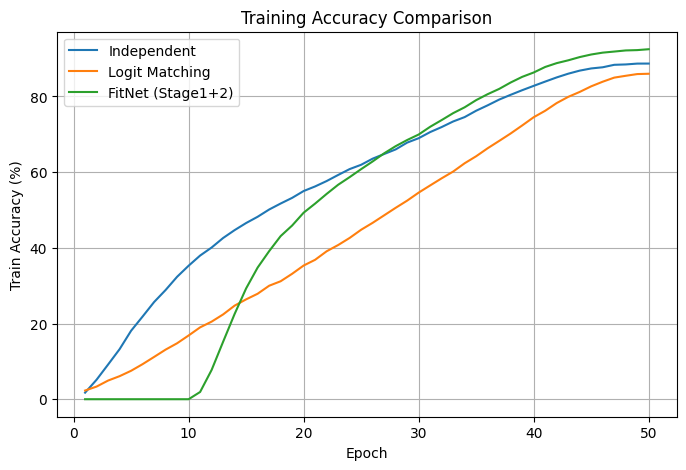

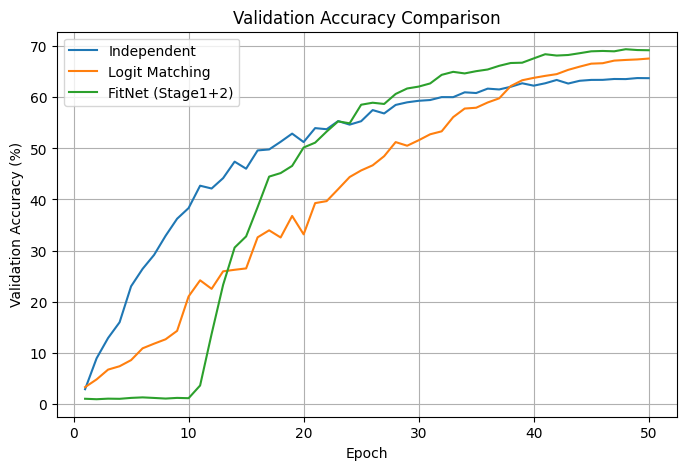

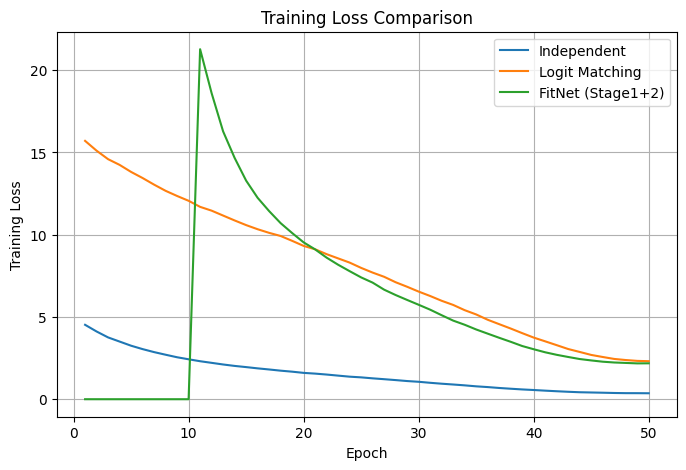

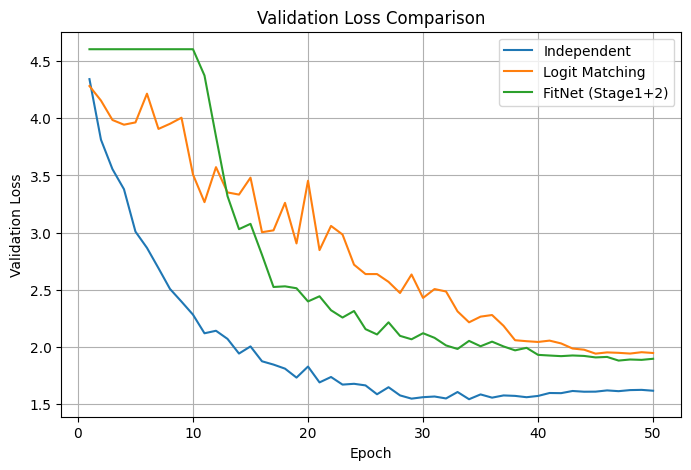

In [ ]:
def unpack_logs(logs, tr_loss_idx, tr_acc_idx, val_loss_idx, val_acc_idx):
    epochs = [r[0] for r in logs]
    tr_loss = [r[tr_loss_idx] for r in logs]
    tr_acc = [r[tr_acc_idx] for r in logs] if tr_acc_idx is not None else [0]*len(logs)
    val_loss = [r[val_loss_idx] for r in logs]
    val_acc = [r[val_acc_idx] for r in logs]
    return epochs, tr_loss, tr_acc, val_loss, val_acc


# Adjust indices per log type
ep_ind, trL_ind, trA_ind, valL_ind, valA_ind = unpack_logs(logs_ind, 1, 2, 3, 4)
ep_lm, trL_lm, trA_lm, valL_lm, valA_lm = unpack_logs(logs_lm, 1, 2, 4, 5)
ep_fit1, trL_fit1, _, valL_fit1, valA_fit1 = unpack_logs(logs_stage1, 1, None, 2, 3)
ep_fit2, trL_fit2, trA_fit2, valL_fit2, valA_fit2 = unpack_logs(logs_stage2, 1, 2, 3, 4)

# Combine FitNet stages for full curve
ep_fit = [*ep_fit1, *[e + max(ep_fit1) for e in ep_fit2]]
trL_fit = [*trL_fit1, *trL_fit2]
trA_fit = [*([0]*len(trL_fit1)), *trA_fit2]  # no acc in stage1
valL_fit = [*valL_fit1, *valL_fit2]
valA_fit = [*valA_fit1, *valA_fit2]

# --- Plot 1: Train Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(ep_ind, trA_ind, label='Independent')
plt.plot(ep_lm, trA_lm, label='Logit Matching')
plt.plot(ep_fit, trA_fit, label='FitNet (Stage1+2)')
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy (%)")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Validation Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(ep_ind, valA_ind, label='Independent')
plt.plot(ep_lm, valA_lm, label='Logit Matching')
plt.plot(ep_fit, valA_fit, label='FitNet (Stage1+2)')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 3: Training Loss ---
plt.figure(figsize=(8, 5))
plt.plot(ep_ind, trL_ind, label='Independent')
plt.plot(ep_lm, trL_lm, label='Logit Matching')
plt.plot(ep_fit, trL_fit, label='FitNet (Stage1+2)')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 4: Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(ep_ind, valL_ind, label='Independent')
plt.plot(ep_lm, valL_lm, label='Logit Matching')
plt.plot(ep_fit, valL_fit, label='FitNet (Stage1+2)')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
student_data = {}
for i in range(4):
    logs = np.array(logs_mini_students[i])
    student_data[i] = {
        'epochs': logs[:, 0],
        'train_loss': logs[:, 1],
        'val_loss': logs[:, 2]
    }
logs_ens = np.array(logs_ensemble)
ep_ens = logs_ens[:, 0]
trL_ens = logs_ens[:, 1]
trA_ens = logs_ens[:, 2]
valL_ens = logs_ens[:, 3]
valA_ens = logs_ens[:, 4]

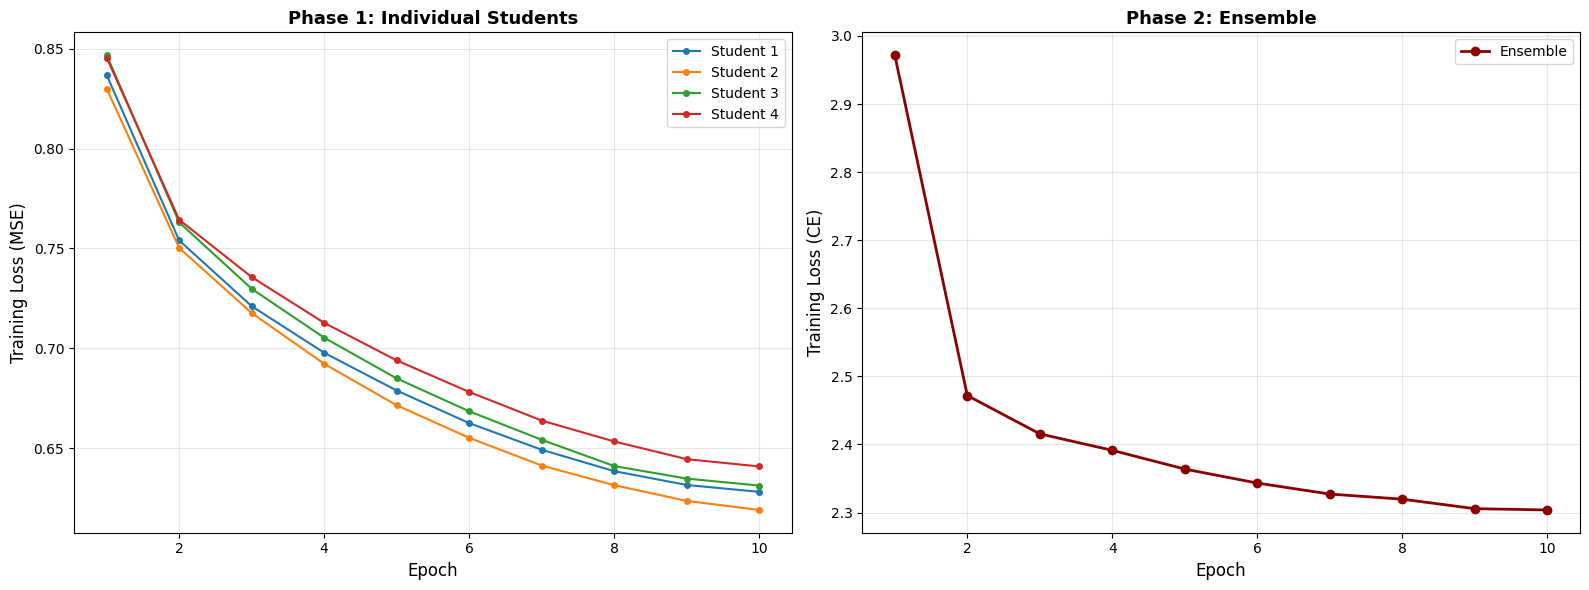

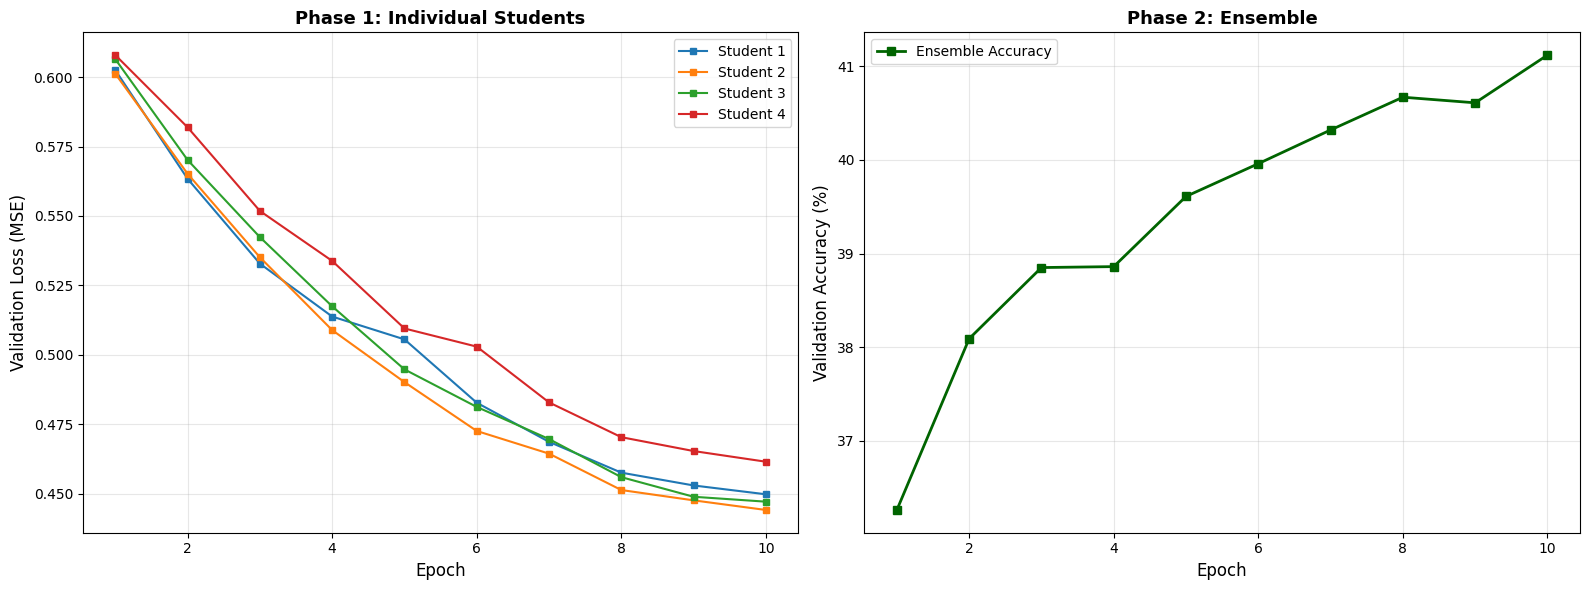

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Individual students
for i in range(4):
    ax1.plot(student_data[i]['epochs'], student_data[i]['train_loss'],
             label=f'Student {i+1}', marker='o', markersize=4)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Training Loss (MSE)", fontsize=12)
ax1.set_title("Phase 1: Individual Students", fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Ensemble
ax2.plot(ep_ens, trL_ens, label='Ensemble', marker='o', markersize=6,
         linewidth=2, color='darkred')
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Training Loss (CE)", fontsize=12)
ax2.set_title("Phase 2: Ensemble", fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Plot 8: Combined View - Validation Performance
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Individual students validation loss
for i in range(4):
    ax1.plot(student_data[i]['epochs'], student_data[i]['val_loss'],
             label=f'Student {i+1}', marker='s', markersize=4)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Validation Loss (MSE)", fontsize=12)
ax1.set_title("Phase 1: Individual Students", fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Ensemble validation accuracy
ax2.plot(ep_ens, valA_ens, label='Ensemble Accuracy', marker='s', markersize=6,
         linewidth=2, color='darkgreen')
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Validation Accuracy (%)", fontsize=12)
ax2.set_title("Phase 2: Ensemble", fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
import torch
import time
import io
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetTotalEnergyConsumption
# !pip install thop
import thop
from torch.profiler import profile, record_function, ProfilerActivity

In [43]:
def profile_baseline_model_simple(model, test_loader, device='cuda', runs=100):
    nvmlInit()
    gpu = nvmlDeviceGetHandleByIndex(0)

    model.to(device)
    model.eval()

    # Get one batch for profiling
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    # Warmup
    for _ in range(10):
        with torch.no_grad():
            _ = model(images)
    torch.cuda.synchronize()

    # Start energy measurement
    start_energy = nvmlDeviceGetTotalEnergyConsumption(gpu)

    # Profiling runs
    total_time = 0
    total_mem = 0

    for _ in range(runs):
        torch.cuda.reset_peak_memory_stats()

        start_t = time.time()
        with torch.no_grad():
            outputs = model(images)
        torch.cuda.synchronize()
        end_t = time.time()

        total_time += (end_t - start_t) * 1000  # ms
        total_mem += torch.cuda.memory_allocated(device) / (1024 ** 2)  # MB

    # Calculate metrics
    avg_latency = total_time / runs
    avg_mem = total_mem / runs
    peak_mem = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

    end_energy = nvmlDeviceGetTotalEnergyConsumption(gpu)
    avg_energy = (end_energy - start_energy) / runs

    # Model size
    buf = io.BytesIO()
    torch.save(model.state_dict(), buf)
    model_size = len(buf.getvalue()) / (1024 ** 2)

    # Calculate MACs
    macs, _ = thop.profile(model, inputs=(images,), verbose=False)

    # Print summary
    print("\n========== Profiling Summary ==========")
    print(f"Runs:            {runs}")
    print(f"Model Size:      {model_size:.2f} MB")
    print(f"Average Latency: {avg_latency:.2f} ms")
    print(f"Peak Memory:     {peak_mem:.2f} MB")
    print(f"Mean Memory:     {avg_mem:.2f} MB")
    print(f"Energy / Run:    {avg_energy:.2f} mJ")
    print(f"MACs / Batch:    {macs / 1e6:.2f} M")
    print("=======================================\n")

    return {
        "model_size_mb": model_size,
        "latency_ms": avg_latency,
        "avg_mem_mb": avg_mem,
        "peak_mem_mb": peak_mem,
        "energy_mJ": avg_energy,
        "macs": macs
    }

In [ ]:
results = profile_baseline_model_simple(student_ind, test_loader, device='cuda', runs=100)
print(f"Latency: {results['latency_ms']:.2f} ms")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



========== Profiling Summary ==========
Runs:            100
Model Size:      37.43 MB
Average Latency: 8.91 ms
Peak Memory:     1460.53 MB
Mean Memory:     1379.66 MB
Energy / Run:    609.23 mJ
MACs / Batch:    19705.10 M

Latency: 8.91 ms


In [ ]:
results = profile_baseline_model_simple(student_lm, test_loader, device='cuda', runs=100)
print(f"Latency: {results['latency_ms']:.2f} ms")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



========== Profiling Summary ==========
Runs:            100
Model Size:      37.43 MB
Average Latency: 8.95 ms
Peak Memory:     1460.53 MB
Mean Memory:     1379.66 MB
Energy / Run:    623.65 mJ
MACs / Batch:    19705.10 M

Latency: 8.95 ms


In [ ]:
results = profile_baseline_model_simple(student_hint, test_loader, device='cuda', runs=100)
print(f"Latency: {results['latency_ms']:.2f} ms")


========== Profiling Summary ==========
Runs:            100
Model Size:      37.43 MB
Average Latency: 8.82 ms
Peak Memory:     1460.53 MB
Mean Memory:     1379.66 MB
Energy / Run:    632.66 mJ
MACs / Batch:    26952.86 M

Latency: 8.82 ms


In [44]:
results = profile_baseline_model_simple(ensemble, test_loader, device='cuda', runs=100)
print(f"Latency: {results['latency_ms']:.2f} ms")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



========== Profiling Summary ==========
Runs:            100
Model Size:      37.06 MB
Average Latency: 14.08 ms
Peak Memory:     305.88 MB
Mean Memory:     265.66 MB
Energy / Run:    950.87 mJ
MACs / Batch:    19992.67 M

Latency: 14.08 ms
